## LSTM VS LSTM + Attention Predictions
The objective of this project is to use time series from a set of Netflix stocks data and then to sample
predict the closing quantities using an LSTM and LSTM + Attention model

### Gates and States
Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) designed to handle sequence data and address the vanishing gradient problem. It consists of a series of gates and hidden states that help the model remember long-term dependencies in the data. There are three types of gates in an LSTM: input gate, forget gate, and output gate.

- **Input gate:** The input gate decides how much of the new information should be stored in the cell state. It uses a sigmoid activation function that outputs values between 0 (retain nothing) and 1 (retain everything).

- **Forget gate:** This gate controls how much of the previous cell state should be forgotten. It also uses a sigmoid activation function. A value close to 0 means forget more, and a value close to 1 means forget less.

- **Output gate:** The output gate determines what information should be output from the cell state and passed on to the next layer. Its activation function is a combination of sigmoid (for deciding what information to pass) and tanh (to scale the values).


<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/lstmts.png"
width="800">


In [78]:
!pip install keras_self_attention -q

In [79]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as smi
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention

import warnings
warnings.simplefilter('ignore')

In [ ]:
import yfinance as yf

start_date = '2015-01-01'
end_date = '2024-03-13'

netflix_data = yf.download('NFLX', start=start_date, end=end_date)
netflix_data.to_csv('netflix_stock_data.csv')

[*********************100%%**********************]  1 of 1 completed


In [80]:
 df = pd.read_csv('netflix_stock_data.csv')
 df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,49.151428,50.331429,48.731430,49.848572,49.848572,13475000
1,2015-01-05,49.258572,49.258572,47.147144,47.311428,47.311428,18165000
2,2015-01-06,47.347141,47.639999,45.661430,46.501431,46.501431,16037700
3,2015-01-07,47.347141,47.421429,46.271427,46.742859,46.742859,9849700
4,2015-01-08,47.119999,47.835712,46.478573,47.779999,47.779999,9601900
...,...,...,...,...,...,...,...
2308,2024-03-06,602.989990,607.929993,593.559998,597.690002,597.690002,2469600
2309,2024-03-07,599.340027,610.530029,595.900024,608.510010,608.510010,2742800
2310,2024-03-08,608.270020,616.090027,600.840027,604.820007,604.820007,2774600
2311,2024-03-11,608.080017,611.000000,600.369995,600.929993,600.929993,2500900


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2313 entries, 0 to 2312
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2313 non-null   object 
 1   Open       2313 non-null   float64
 2   High       2313 non-null   float64
 3   Low        2313 non-null   float64
 4   Close      2313 non-null   float64
 5   Adj Close  2313 non-null   float64
 6   Volume     2313 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 126.6+ KB


In [82]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2313.0,3.039272e+02,1.600952e+02,4.602143e+01,1.467000e+02,3.145700e+02,4.214000e+02,6.923500e+02
High,2313.0,3.085415e+02,1.621005e+02,4.678571e+01,1.477000e+02,3.202200e+02,4.275200e+02,7.009900e+02
Low,2313.0,2.991784e+02,1.579203e+02,4.526429e+01,1.449100e+02,3.080100e+02,4.145000e+02,6.860900e+02
Close,2313.0,3.039732e+02,1.599908e+02,4.554714e+01,1.464700e+02,3.153400e+02,4.214200e+02,6.916900e+02
Adj Close,2313.0,3.039732e+02,1.599908e+02,4.554714e+01,1.464700e+02,3.153400e+02,4.214200e+02,6.916900e+02
Volume,2313.0,9.400000e+06,8.161345e+06,1.144000e+06,4.709300e+06,7.033200e+06,1.134010e+07,1.333875e+08


In [83]:
df.mean()

Open         3.039272e+02
High         3.085415e+02
Low          2.991784e+02
Close        3.039732e+02
Adj Close    3.039732e+02
Volume       9.400000e+06
dtype: float64

In [84]:
df.median()

Open         3.145700e+02
High         3.202200e+02
Low          3.080100e+02
Close        3.153400e+02
Adj Close    3.153400e+02
Volume       7.033200e+06
dtype: float64

In [85]:
df.skew()

Open         0.209215
High         0.198925
Low          0.217547
Close        0.206799
Adj Close    0.206799
Volume       4.476619
dtype: float64

In [86]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Exploratory Data Analysis

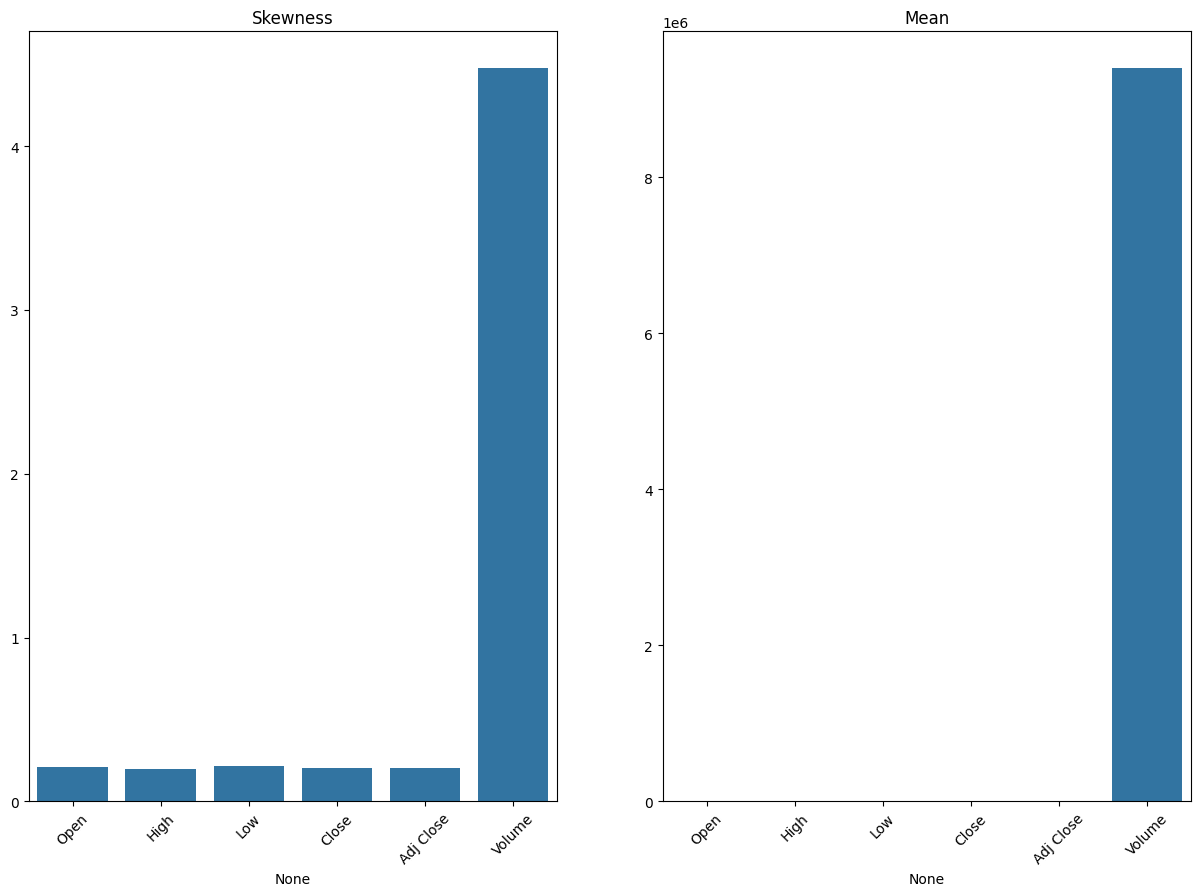

In [87]:
skewness_values = df.skew()
mean_values = df.mean()
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sns.barplot(x=skewness_values.index, y=skewness_values.values, ax=ax[0])
ax[0].set_title('Skewness')
ax[0].tick_params(axis='x', rotation=45)
sns.barplot(x=mean_values.index, y=mean_values.values, ax=ax[1])
ax[1].set_title('Mean')
ax[1].tick_params(axis='x', rotation=45)
plt.show()

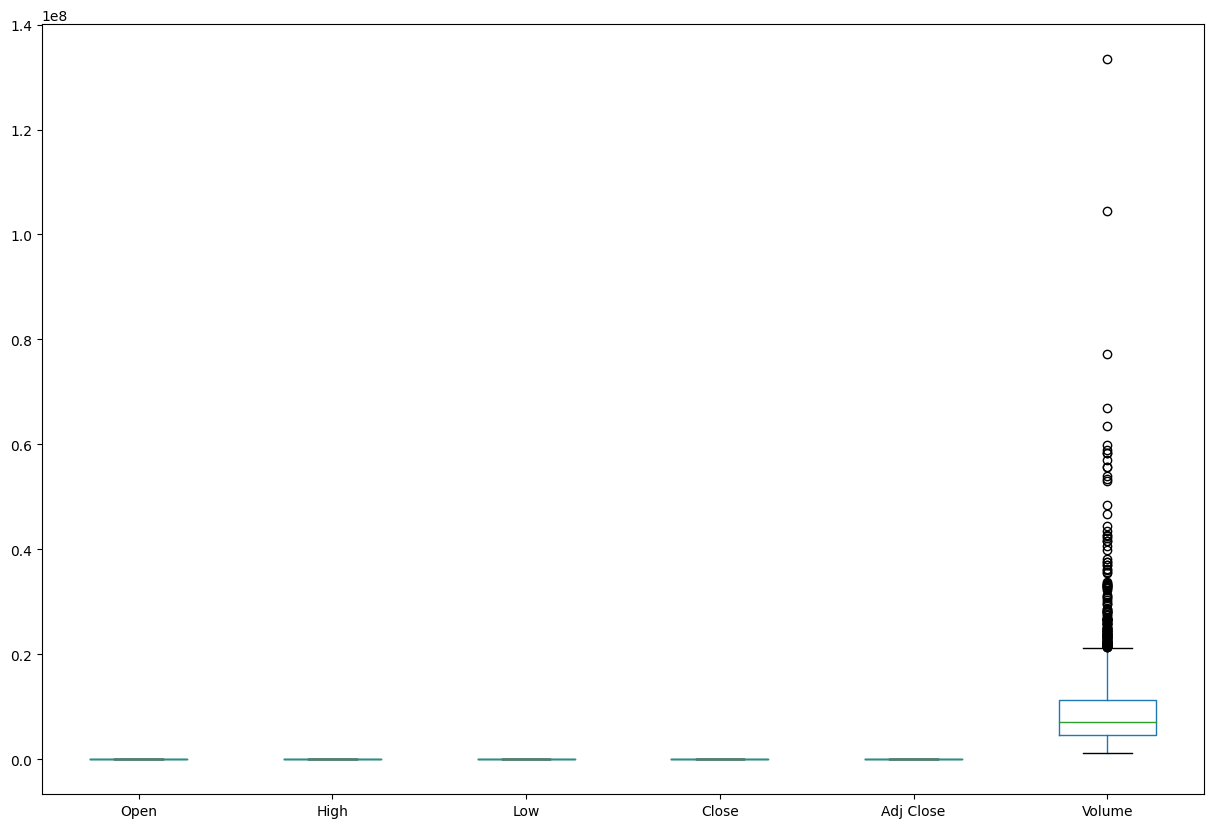

In [88]:
df.boxplot(figsize =(15,10), grid = False)
plt.show()

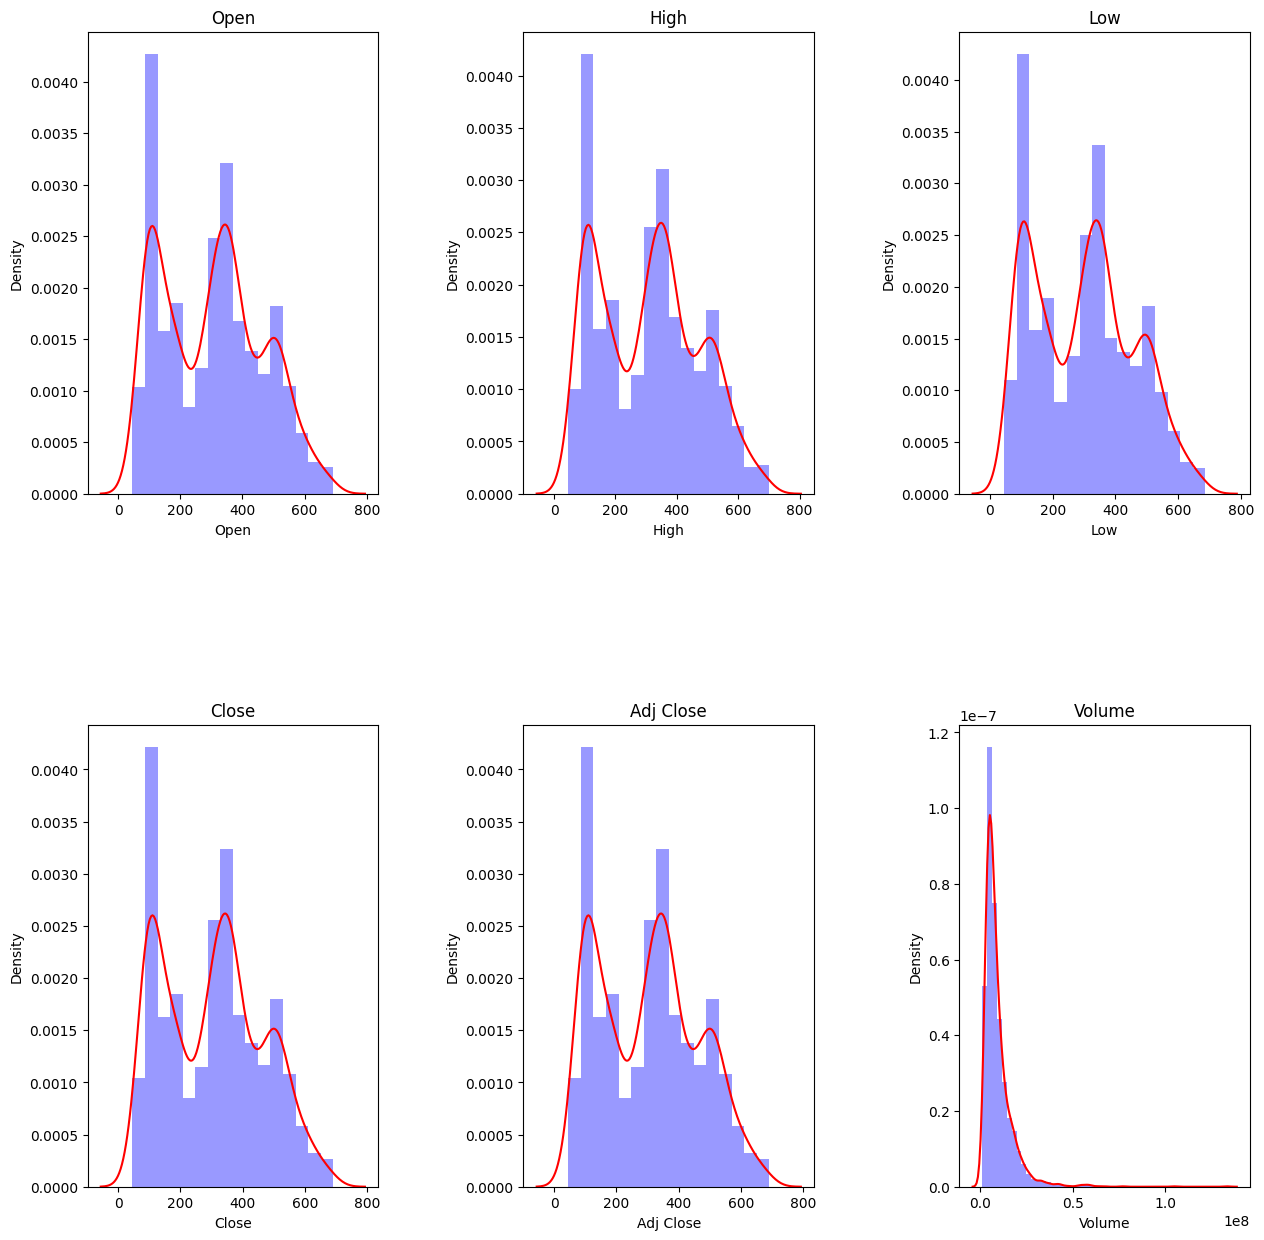

In [89]:
columnas_por_fila = 3

num_columnas = len(df.describe().columns)
num_filas = -(-num_columnas // columnas_por_fila)

fig, ax = plt.subplots(num_filas, columnas_por_fila, figsize=(15, 15))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, columna in enumerate(df.describe().columns):
    fila_actual = i // columnas_por_fila
    columna_actual = i % columnas_por_fila
    sns.distplot(df[columna], ax=ax[fila_actual, columna_actual], color='red',hist_kws={'color': 'blue'})
    ax[fila_actual, columna_actual].set_title(columna)
plt.show()

### Q-Q Plot

A Q-Q plot, short for quantile-quantile plot, is a graphical tool used to assess whether or not a dataset follows a particular probability distribution, such as a normal distribution.

In a Q-Q plot, the quantiles of the sample data are plotted against the quantiles of the theoretical distribution. If the sample data comes from the specified theoretical distribution, the points in the Q-Q plot will fall approximately along a straight line.

Specifically, the x-axis represents the quantiles of the theoretical distribution, while the y-axis represents the quantiles of the sample data. If the sample data is normally distributed, the points in the Q-Q plot will fall along a 45-degree line. Deviations from this line indicate deviations from the specified distribution.

Q-Q plots are useful for visually assessing the goodness-of-fit of a dataset to a particular distribution, allowing you to determine whether the assumptions underlying your statistical analysis are met. They are commonly used in statistics, data analysis, and quality control to check the normality assumption or to compare empirical distributions to theoretical ones.

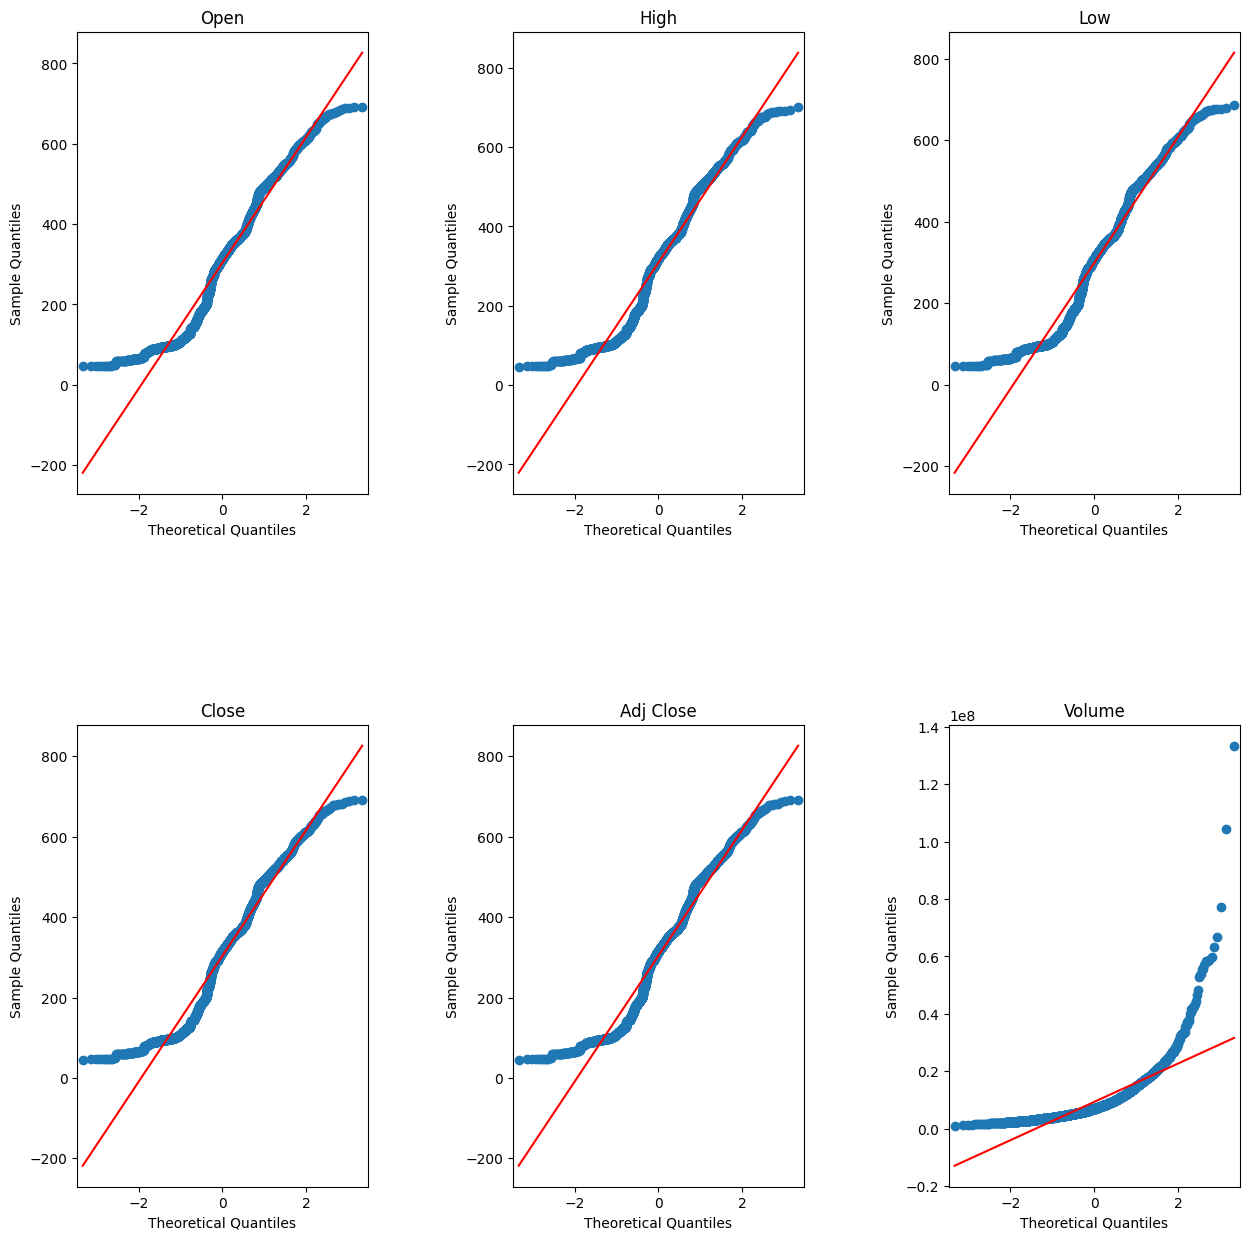

In [90]:
columnas_por_fila = 3

num_columnas = len(df.describe().columns)
num_filas = -(-num_columnas // columnas_por_fila)

fig, ax = plt.subplots(num_filas, columnas_por_fila, figsize=(15, 15))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, columna in enumerate(df.describe().columns):
    fila_actual = i // columnas_por_fila
    columna_actual = i % columnas_por_fila
    smi.qqplot(df[columna], ax=ax[fila_actual, columna_actual],line="r")
    ax[fila_actual, columna_actual].set_title(columna)

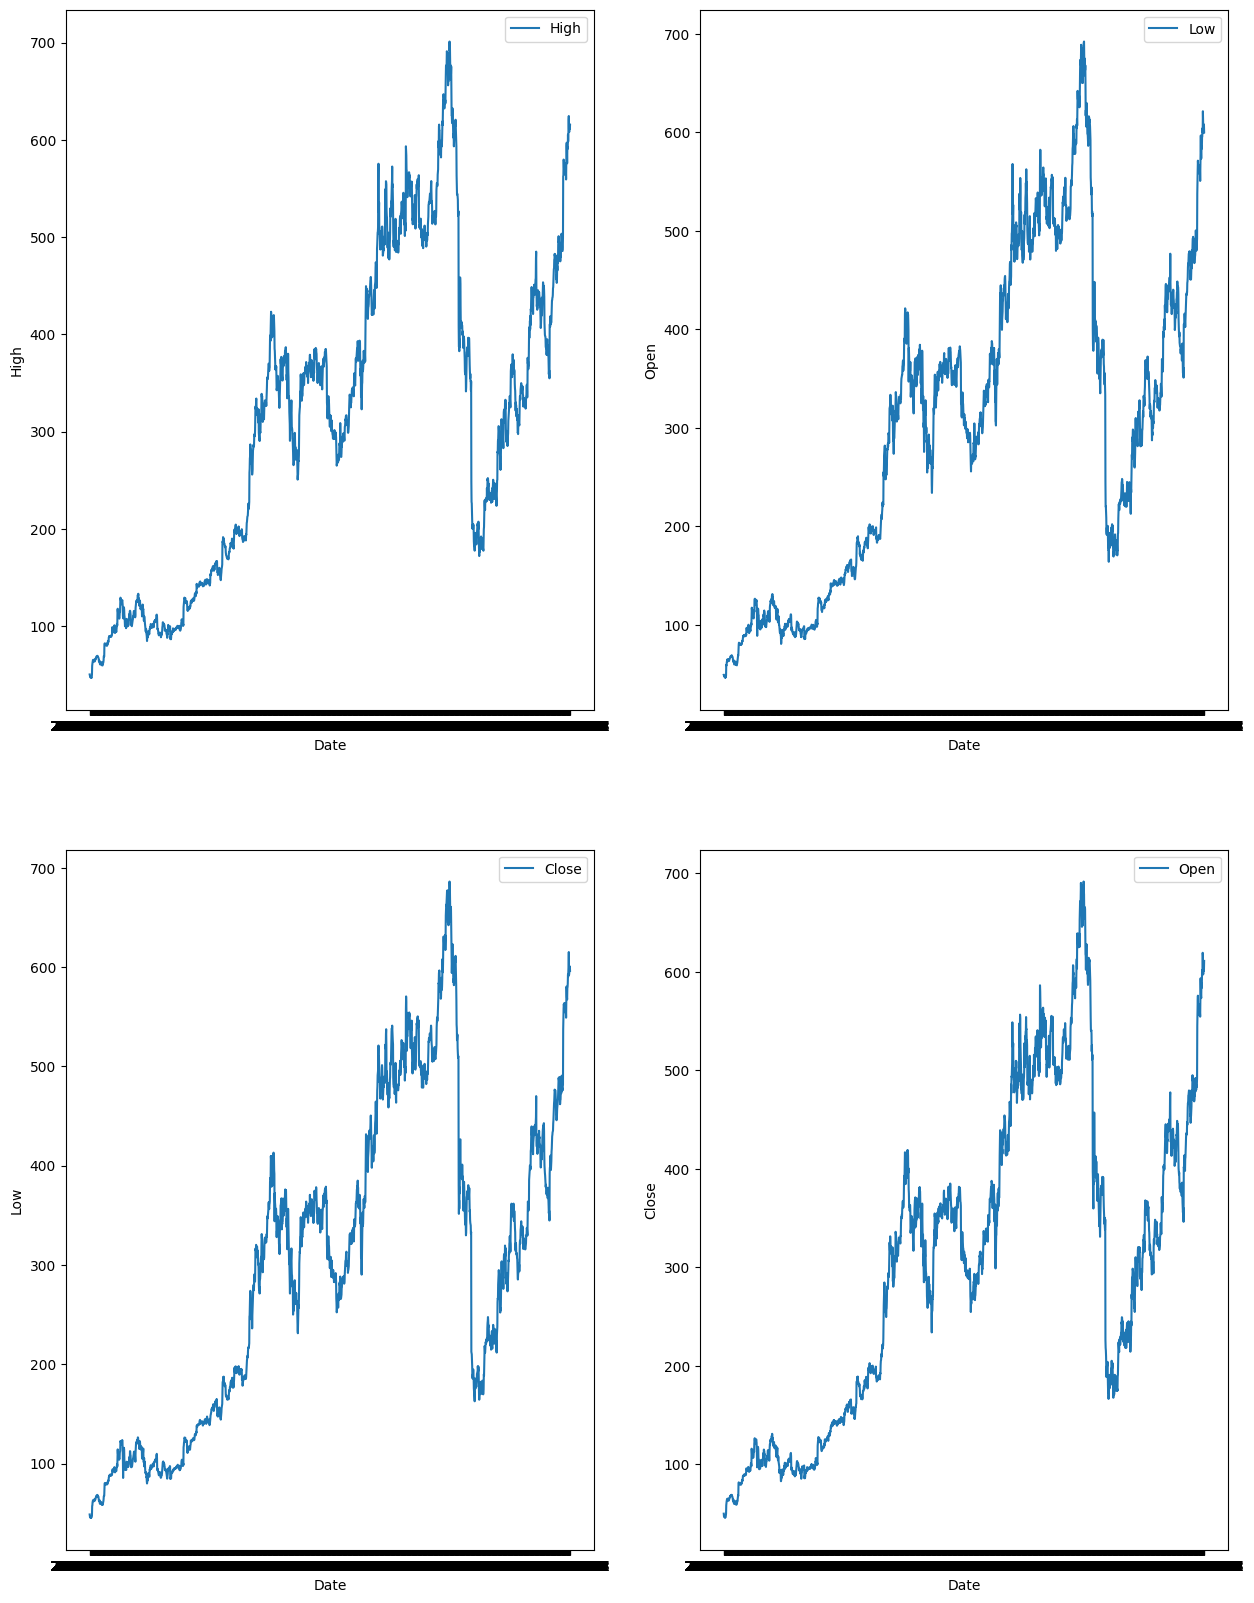

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(15, 20))
sns.lineplot(data=df, x='Date', y='High', label='High', ax = ax[0,0])
sns.lineplot(data=df, x='Date', y='Open', label='Low',ax = ax[0,1])
sns.lineplot(data=df, x='Date', y='Low', label='Close',ax = ax[1,0])
sns.lineplot(data=df, x='Date', y='Close', label='Open',ax = ax[1,1])
plt.show()

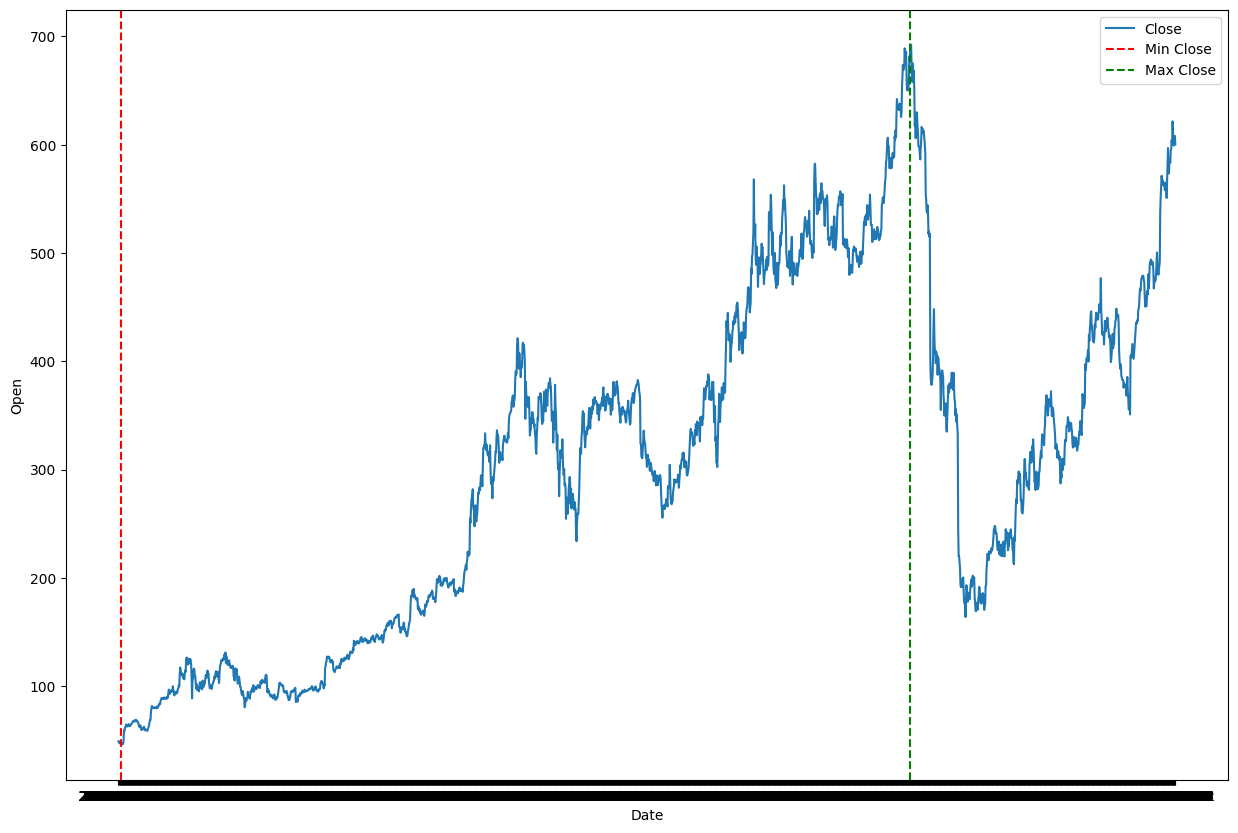

In [92]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df, x='Date', y='Open', label='Close')
min_index = df['Close'].idxmin()
max_index = df['Close'].idxmax()
min_date = df.loc[min_index, 'Date']
max_date = df.loc[max_index, 'Date']
plt.axvline(x=min_date, color='r', linestyle='--', label='Min Close')
plt.axvline(x=max_date, color='g', linestyle='--', label='Max Close')
plt.legend()
plt.show()

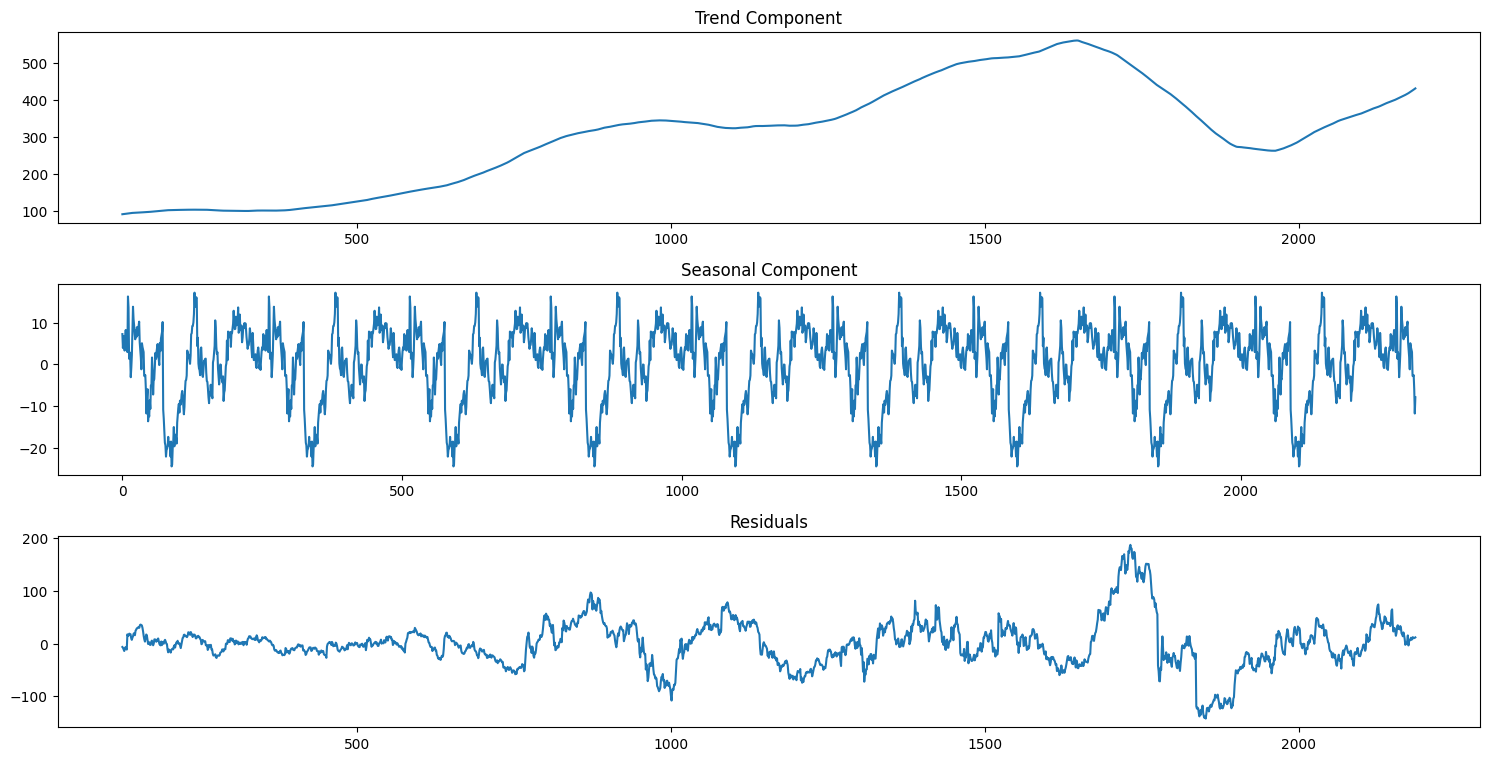

In [93]:
result = seasonal_decompose(df['Close'], model='additive', period=252)
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(result.trend, label='Trend')
plt.title('Trend Component')
plt.subplot(4, 1, 2)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.subplot(4, 1, 3)
plt.plot(result.resid, label='Residuals')
plt.title('Residuals')
plt.tight_layout()
plt.show()

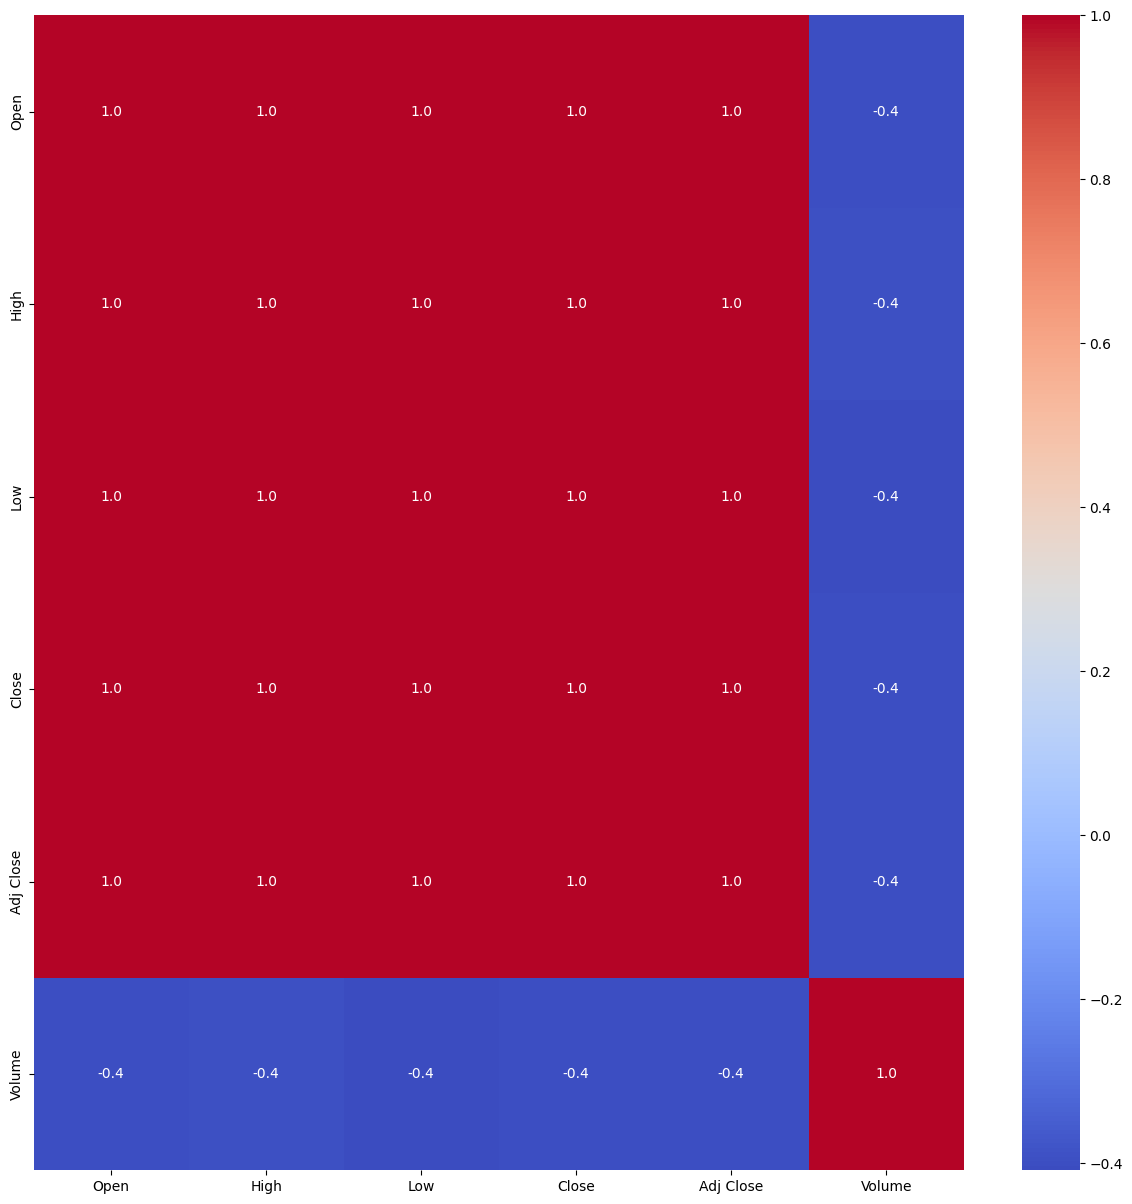

In [94]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot = True, fmt = '.1f', cmap='coolwarm')
plt.show()

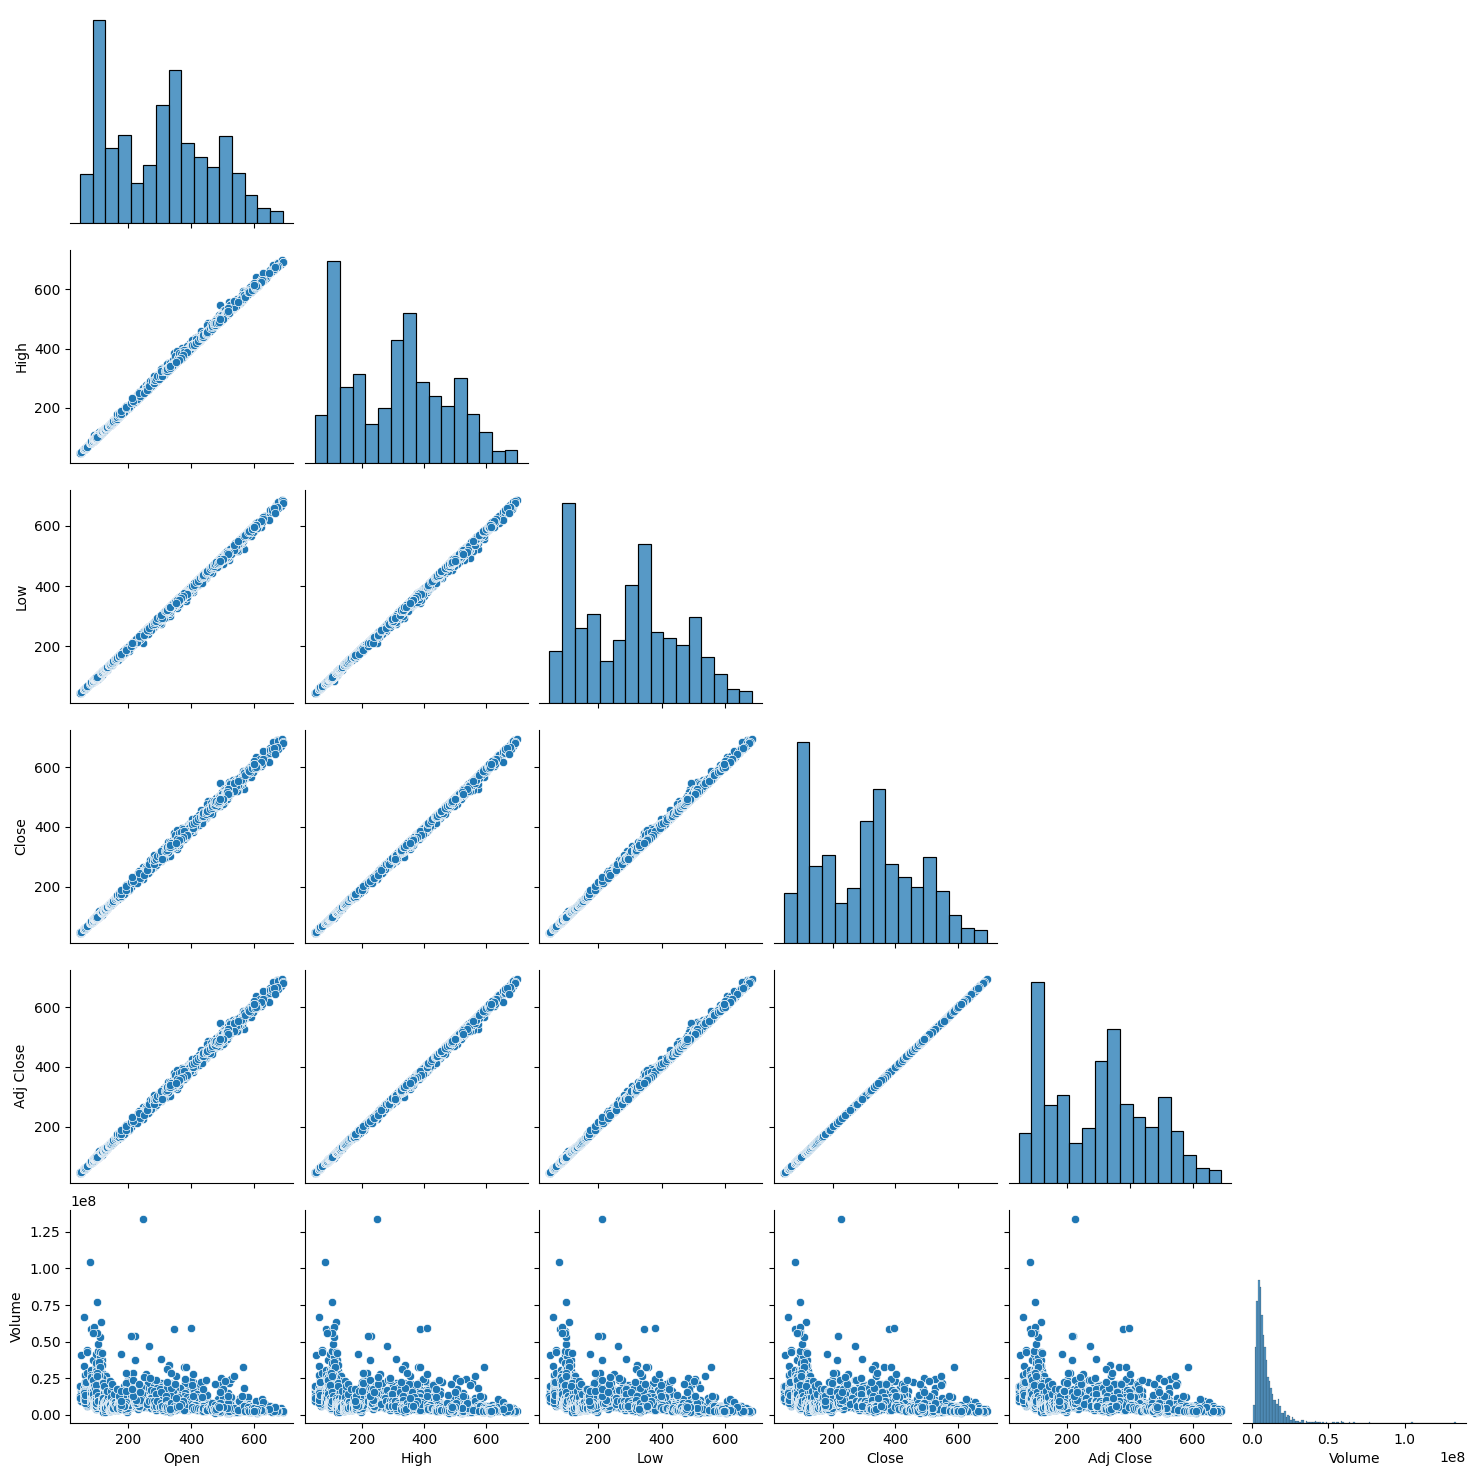

In [95]:
sns.pairplot(df,corner=True)
plt.show()

### Time Series Modeling and Evaluation

In [96]:
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

 it is a two-dimensional array (or a DataFrame) with many rows and columns, and seq_length is 4, the function will take every sequence of 4 consecutive rows from the data and return a list of such sequences. Each sequence will be a one-dimensional array containing the values of the first column of the selected rows.

In [97]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length, 0]
        label = data[i + seq_length, 0]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [98]:
seq_length = 4
n_samples = len(data_scaled)
sequences, labels = create_sequences(data_scaled, seq_length)

In [99]:
len(sequences)

2309

In [100]:
split = int(0.8 * len(sequences))

In [101]:
seq_length = 4
n_samples = len(data_scaled)
sequences, labels = create_sequences(data_scaled, seq_length)
split = int(0.8 * len(sequences))

X_train, y_train = sequences[:split], labels[:split]
X_test, y_test = sequences[split:], labels[split:]

In [102]:
model_lstm = Sequential()

model_lstm.add(LSTM(100, activation='relu', input_shape=(seq_length, 1),return_sequences=True))
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(Dense(1)) # regression

In [103]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 4, 100)            40800     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [104]:
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [105]:
model_lstm.fit(X_train, y_train,
               epochs=20,
               batch_size=32,
               validation_data=(X_test, y_test)
               )

Epoch 1/20
58/58 [==============================] - 3s 14ms/step - loss: 0.0823 - val_loss: 0.0058
Epoch 2/20
58/58 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 5.7128e-04
Epoch 3/20
58/58 [==============================] - 0s 8ms/step - loss: 5.4092e-04 - val_loss: 5.4866e-04
Epoch 4/20
58/58 [==============================] - 0s 8ms/step - loss: 4.9974e-04 - val_loss: 5.1336e-04
Epoch 5/20
58/58 [==============================] - 0s 9ms/step - loss: 4.8439e-04 - val_loss: 5.0180e-04
Epoch 6/20
58/58 [==============================] - 1s 10ms/step - loss: 4.7705e-04 - val_loss: 5.0756e-04
Epoch 7/20
58/58 [==============================] - 1s 10ms/step - loss: 4.9979e-04 - val_loss: 4.9795e-04
Epoch 8/20
58/58 [==============================] - 0s 8ms/step - loss: 4.8703e-04 - val_loss: 4.9500e-04
Epoch 9/20
58/58 [==============================] - 1s 9ms/step - loss: 4.7148e-04 - val_loss: 5.4290e-04
Epoch 10/20
58/58 [==============================] - 1s

In [106]:
predictions_lstm = model_lstm.predict(X_test)

15/15 [==============================] - 0s 3ms/step


### Make anti-trasformation!!!

In [107]:
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

In [108]:
dates_test = df['Date'].iloc[split + seq_length:]
df_plot_lstm = pd.DataFrame({'Date': dates_test,
                                       'Real': y_test_actual_LSTM.flatten(),
                                       'Predict': predictions_LSTM.flatten()
                                       })
df_plot_lstm.head()

,Date,Real,Predict
1851,2022-05-10,177.660004,194.009705
1852,2022-05-11,166.369995,184.650269
1853,2022-05-12,174.309998,179.107529
1854,2022-05-13,187.639999,176.080505
1855,2022-05-16,186.509995,177.665009


### LSTM + ATTENTION

SeqSelfAttention is an attention mechanism used for processing sequential data that considers the context for each timestamp. It is a part of the Keras Self-Attention package and can be added to models to enhance their performance in tasks involving sequential data processing
1
. This attention layer calculates relevance by considering the whole context, and it can be integrated into models following specific configurations, such as using additive attention and defining activation functions for attention mechanisms


In [110]:
model_lstm_attention = Sequential()

model_lstm_attention.add(LSTM(100, activation='relu', input_shape=(seq_length,1), return_sequences=True))
model_lstm_attention.add(SeqSelfAttention(attention_activation='relu'))
model_lstm_attention.add(LSTM(50, activation='relu', return_sequences=False))
model_lstm_attention.add(Dense(1))

In [111]:
model_lstm_attention.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 4, 100)            40800     
                                                                 
 seq_self_attention_2 (SeqS  (None, 4, 100)            6465      
 elfAttention)                                                   
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 77516 (302.80 KB)
Trainable params: 77516 (302.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
model_lstm_attention.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [113]:
model_lstm_attention.fit(X_train, y_train,
                         epochs=20,
                         batch_size=32,
                         validation_data=(X_test, y_test)
                         )

Epoch 1/20
58/58 [==============================] - 5s 28ms/step - loss: 0.0631 - val_loss: 0.0017
Epoch 2/20
58/58 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 5.3833e-04
Epoch 3/20
58/58 [==============================] - 1s 17ms/step - loss: 5.4471e-04 - val_loss: 5.5481e-04
Epoch 4/20
58/58 [==============================] - 1s 22ms/step - loss: 5.2792e-04 - val_loss: 5.2800e-04
Epoch 5/20
58/58 [==============================] - 1s 21ms/step - loss: 4.7898e-04 - val_loss: 5.0608e-04
Epoch 6/20
58/58 [==============================] - 1s 19ms/step - loss: 4.8350e-04 - val_loss: 4.9091e-04
Epoch 7/20
58/58 [==============================] - 1s 16ms/step - loss: 4.8873e-04 - val_loss: 5.0354e-04
Epoch 8/20
58/58 [==============================] - 1s 15ms/step - loss: 4.7208e-04 - val_loss: 5.7877e-04
Epoch 9/20
58/58 [==============================] - 1s 11ms/step - loss: 4.6296e-04 - val_loss: 5.3839e-04
Epoch 10/20
58/58 [==============================

In [114]:
predictions_scaled_RNN = model_lstm_attention.predict(X_test)

15/15 [==============================] - 0s 5ms/step


### Make inverse-trasnformations

In [115]:
predictions_lstm_attention = scaler.inverse_transform(predictions_scaled_RNN)
y_test_lstm_attention = scaler.inverse_transform(y_test.reshape(-1, 1))

In [116]:
df_plot_lstm_attention = pd.DataFrame({'Date': dates_test,
                                        'Real': y_test_lstm_attention.flatten(),
                                        'Predict': predictions_lstm_attention.flatten()
                                        })
df_plot_lstm_attention.head()

,Date,Real,Predict
1851,2022-05-10,177.660004,194.606201
1852,2022-05-11,166.369995,184.891876
1853,2022-05-12,174.309998,179.307617
1854,2022-05-13,187.639999,176.090469
1855,2022-05-16,186.509995,177.513016


### Visualization

In [117]:
df_plot_lstm['Error_Real'] = df_plot_lstm['Real'] - df_plot_lstm['Predict']
df_plot_lstm_attention['Error_Real'] = df_plot_lstm_attention['Real'] -df_plot_lstm_attention['Predict']

In [118]:
mse_lstm = mean_squared_error(df_plot_lstm['Real'], df_plot_lstm['Predict'])
mse_rnn = mean_squared_error(df_plot_lstm_attention['Real'],df_plot_lstm_attention['Predict'])

r2_lstm = r2_score(df_plot_lstm['Real'], df_plot_lstm['Predict'])
r2_rnn = r2_score(df_plot_lstm_attention['Real'],df_plot_lstm_attention['Predict'])

rmse_lstm = mean_squared_error(df_plot_lstm['Real'], df_plot_lstm['Predict'],squared=False)
rmse_rnn = mean_squared_error(df_plot_lstm_attention['Real'],df_plot_lstm_attention['Predict'], squared=False)

In [120]:
# Format the date labels

from matplotlib.dates import MonthLocator, DateFormatter
locator = MonthLocator()

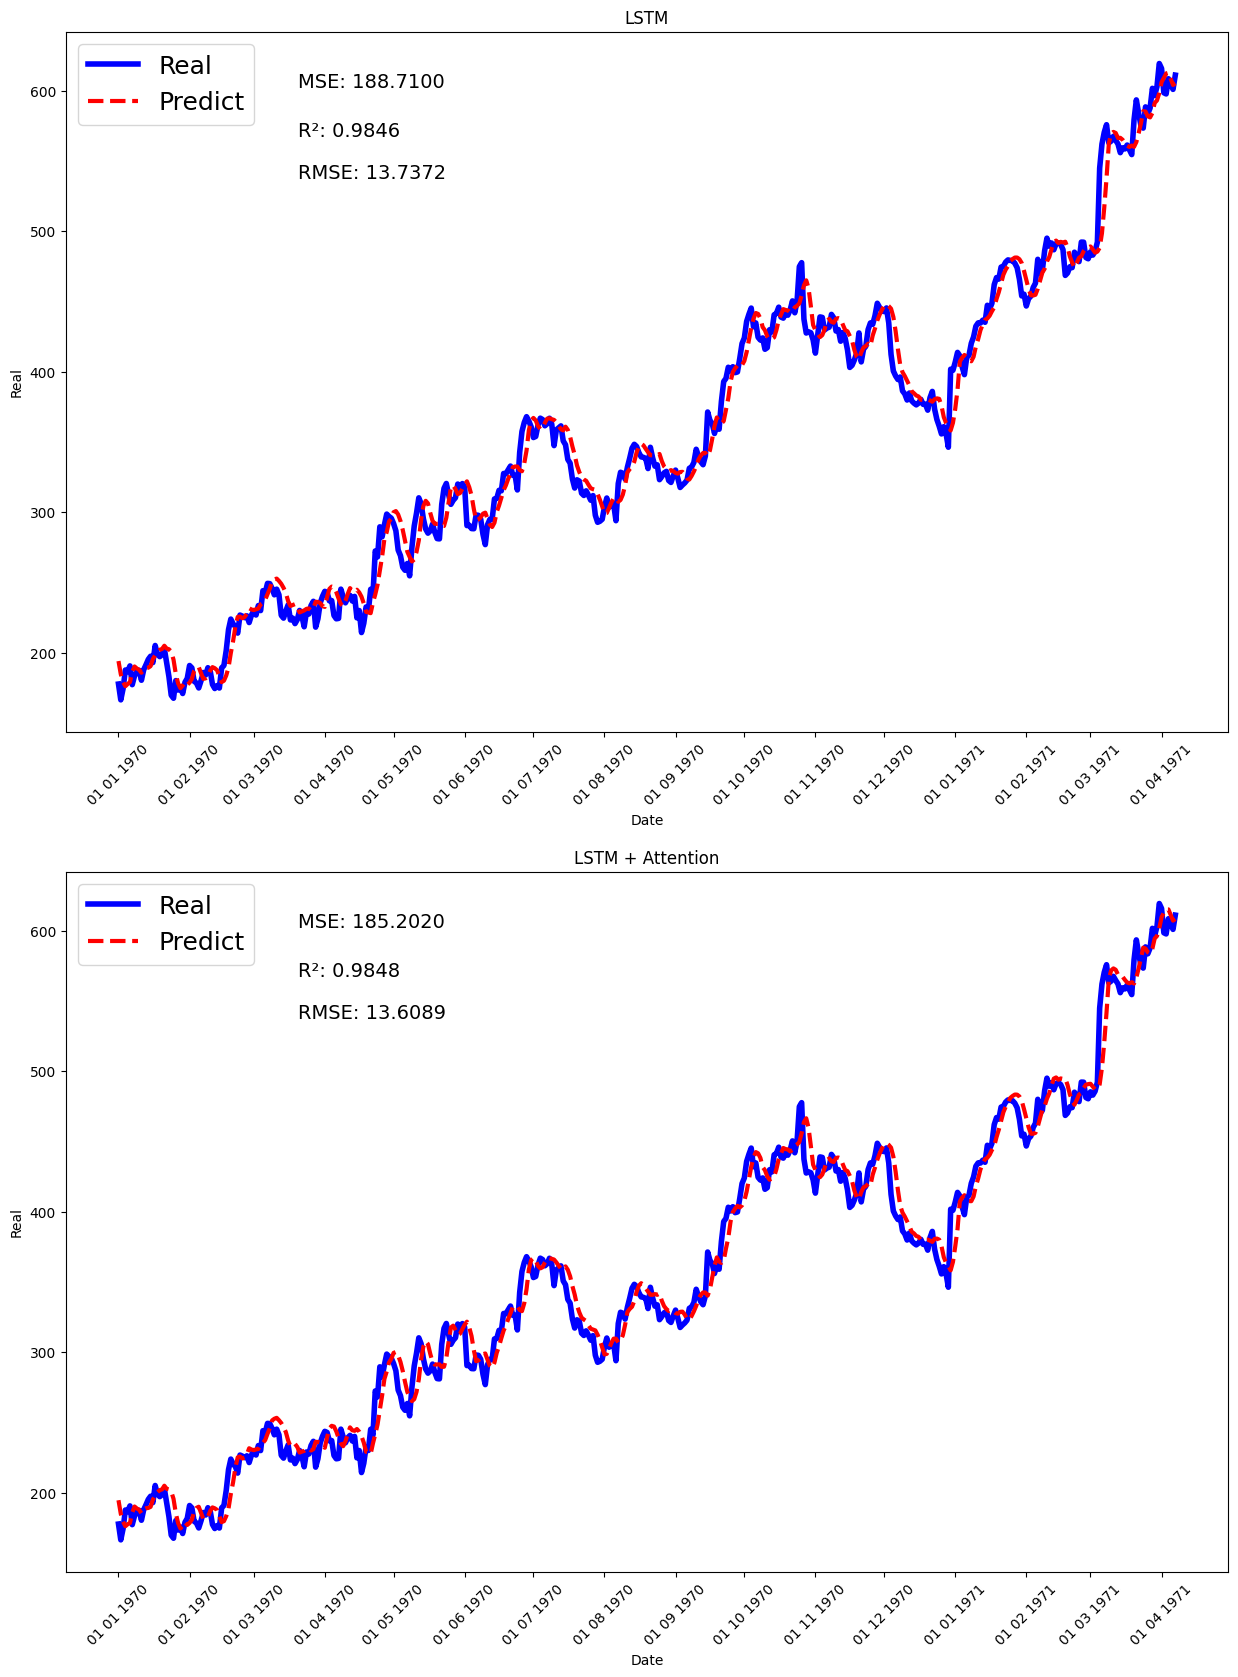

In [121]:
fig, ax = plt.subplots(2, 1, figsize=(15, 20))

## PLOT LSTM model
sns.lineplot(x='Date', y='Real', data=df_plot_lstm, label='Real',color='blue', ax=ax[0],linewidth=4)
sns.lineplot(x='Date', y='Predict', data=df_plot_lstm,label='Predict',color='red', linestyle='dashed', ax=ax[0],linewidth=3)

ax[0].text(0.2, 0.85, f'R²: {r2_lstm:.4f}', fontsize=14, color='black',transform=ax[0].transAxes)
ax[0].text(0.2, 0.92, f'MSE: {mse_lstm:.4f}', fontsize=14, color='black',transform=ax[0].transAxes)
ax[0].text(0.2, 0.79, f'RMSE: {rmse_lstm:.4f}', fontsize=14, color='black',transform=ax[0].transAxes)
ax[0].set_title('LSTM')
ax[0].legend(fontsize=18)
ax[0].set_xlabel('Date')
ax[0].xaxis.set_major_locator(locator)
ax[0].xaxis.set_major_formatter(DateFormatter('%d %m %Y'))
ax[0].tick_params(axis='x', rotation=45)

## PLOT LSTM + with Attention model
sns.lineplot(x='Date', y='Real', data=df_plot_lstm_attention, label='Real',color='blue', ax=ax[1],linewidth=4)
sns.lineplot(x='Date', y='Predict', data=df_plot_lstm_attention,label='Predict', color='red', linestyle='dashed', ax=ax[1],linewidth=3)

ax[1].text(0.2, 0.85, f'R²: {r2_rnn:.4f}', fontsize=14, color='black',transform=ax[1].transAxes)
ax[1].text(0.2, 0.92, f'MSE: {mse_rnn:.4f}', fontsize=14, color='black',transform=ax[1].transAxes)
ax[1].text(0.2, 0.79, f'RMSE: {rmse_rnn:.4f}', fontsize=14, color='black',transform=ax[1].transAxes)
ax[1].set_title('LSTM + Attention')
ax[1].legend(fontsize=18)
ax[1].xaxis.set_major_formatter(DateFormatter('%d %m %Y'))
ax[1].xaxis.set_major_locator(locator)
ax[1].tick_params(axis='x', rotation=45)

plt.show()